# Inicializando

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn

# Base de dados baixada a partir do Kaggle: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download
# df = pd.read_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/creditcard.csv')
df = pd.read_csv('creditcard.csv') # Versão PC

atributos_a_serem_descartados = ['Time', 'V1', 'V2', 'V6', 'V8', 'V13', 'V15', 'V18', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28']
atributos_que_ficaram = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'Amount']

#* Atributos importante para a fraude: V3, V4, V5, V7, V9, V10, V11, V12, V14, V16, V17
#* Valores correlacionados negativamente: V17 V14 V12 V10 (Quanto menores mais chances de ser uma fraude)
#* Valores correlacionados positivamente: V2, V4, V11, V19 (Quanto maiores mais chances de ser uma fraude)

#* Atributos importante para o legitimo: V4, Amount

# Atributos que ainda podem ser descartados: V5, V7

df = df.drop(columns = atributos_a_serem_descartados)

print(df.columns)

X = df.to_numpy()

print(len(X[0]))

y = pd.DataFrame(X[:,-1])
X = pd.DataFrame(X[:,:-1])


Index(['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17',
       'V19', 'Amount', 'Class'],
      dtype='object')
14


In [3]:
from sklearn import tree

def get_novo_modelo():
    return tree.DecisionTreeClassifier()

def modelo_fit(modelo, dados, classes):
    return modelo.fit(dados, classes)

def modelo_predict(modelo, dados):
    return modelo.predict(dados)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% Treino e 20% Teste

print(f"Tamanho treino: {len(y_train)}, Qtd fraudes: {len(y_train[y_train == 1])}")
print(f"Tamanho teste: {len(y_test)}, Qtd fraudes: {len(y_test[y_test == 1])}")

Tamanho treino: 227845, Qtd fraudes: 394
Tamanho teste: 56962, Qtd fraudes: 98


# Cross validation

In [7]:
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

skf_outter = StratifiedKFold(n_splits=10)
skf_inner = StratifiedKFold(n_splits=10)

matriz_auc = []
matriz_treino = []
matriz_validacao = []
separacao_treino_geral = []
separacao_teste = []

separa_externa = 0
melhor_separacao_interna = 0
melhor_separacao_externa = 0

for general_train_idx, test_idx in skf_outter.split(X, y):

    X_train = X.loc[general_train_idx]
    y_train = y.loc[general_train_idx]

    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    matriz_auc.append([])
    separacao_treino = []
    separacao_validacao = []
    separa_interna = 0   

    melhor_interno = 0

    for train_idx, val_idx in skf_inner.split(X_train, y_train):

        X_tr = X_train.loc[train_idx]
        y_tr = y_train.loc[train_idx]

        X_val = X_train.loc[val_idx]
        y_val = y_train.loc[val_idx]

        separacao_treino.append(train_idx)
        separacao_validacao.append(val_idx)

        modelo = get_novo_modelo()
        modelo = modelo_fit(modelo, X_tr, y_tr)
        pred = modelo_predict(modelo, X_val)

        acc_score = accuracy_score(y_val, pred)
        precision, recall, _ = precision_recall_curve(y_val, pred)
        auc_score = auc(recall, precision)
        
        print(f"Separação interna: {separa_interna}, Precision/Recall: {auc_score:0.4f}")

        matriz_auc[separa_externa].append(auc_score)

        if  matriz_auc[melhor_separacao_externa][melhor_separacao_interna] < auc_score:
            melhor_separacao_interna = separa_interna
            melhor_separacao_externa = separa_externa
            melhor_interno = auc_score
        
        if melhor_interno < auc_score:
            melhor_interno = auc_score

        separa_interna += 1   
    
    print(f"Separação externa: {separa_externa}, melhor Precision/Recall desse loop: {melhor_interno:0.4f}")

    matriz_treino.append(separacao_treino.copy())
    matriz_validacao.append(separacao_validacao.copy())
    separacao_treino_geral.append(general_train_idx)
    separacao_teste.append(test_idx)

    separa_externa += 1

Separação interna: 0, Precision/Recall: 0.8527
Separação interna: 1, Precision/Recall: 0.8889
Separação interna: 2, Precision/Recall: 0.8006
Separação interna: 3, Precision/Recall: 0.7570
Separação interna: 4, Precision/Recall: 0.5067
Separação interna: 5, Precision/Recall: 0.7766
Separação interna: 6, Precision/Recall: 0.7419
Separação interna: 7, Precision/Recall: 0.7306
Separação interna: 8, Precision/Recall: 0.7639
Separação interna: 9, Precision/Recall: 0.6379
Separação externa: 0, melhor Precision/Recall desse loop: 0.8889
Separação interna: 0, Precision/Recall: 0.5935
Separação interna: 1, Precision/Recall: 0.8495
Separação interna: 2, Precision/Recall: 0.7701
Separação interna: 3, Precision/Recall: 0.7391
Separação interna: 4, Precision/Recall: 0.5420
Separação interna: 5, Precision/Recall: 0.7073
Separação interna: 6, Precision/Recall: 0.5647
Separação interna: 7, Precision/Recall: 0.6972
Separação interna: 8, Precision/Recall: 0.6972
Separação interna: 9, Precision/Recall: 0.

In [8]:
X_test = X.loc[separacao_teste[melhor_separacao_externa]]
y_test = y.loc[separacao_teste[melhor_separacao_externa]]

X_treino_geral = X.loc[separacao_treino_geral[melhor_separacao_externa]]
y_treino_geral = y.loc[separacao_treino_geral[melhor_separacao_externa]]

X_treino_geral = X_treino_geral.reset_index(drop=True)
y_treino_geral = y_treino_geral.reset_index(drop=True)

X_tr = X_treino_geral.loc[matriz_treino[melhor_separacao_externa][melhor_separacao_interna]]
y_tr = y_treino_geral.loc[matriz_treino[melhor_separacao_externa][melhor_separacao_interna]]

X_val = X_treino_geral.loc[matriz_validacao[melhor_separacao_externa][melhor_separacao_interna]]
y_val = y_treino_geral.loc[matriz_validacao[melhor_separacao_externa][melhor_separacao_interna]]

auc_score = 0

# Re-treinamento com a melhor divisão
while matriz_auc[melhor_separacao_externa][melhor_separacao_interna] > auc_score:
    modelo = get_novo_modelo()
    modelo = modelo_fit(modelo, X_tr, y_tr)
    pred = modelo_predict(modelo, X_val)

    acc_score = accuracy_score(y_val, pred)
    precision, recall, _ = precision_recall_curve(y_val, pred)
    auc_score = auc(recall, precision)
    print(f"Precision/Recall: {auc_score:0.4f}, Esperado: {matriz_auc[melhor_separacao_externa][melhor_separacao_interna]}")

print(f"Treinamento finalizado\nAcurácia: {acc_score:0.4f}, Precision/Recall: {auc_score:0.4f}")

Precision/Recall: 0.8843, Esperado: 0.9116197831383672
Precision/Recall: 0.8760, Esperado: 0.9116197831383672
Precision/Recall: 0.8843, Esperado: 0.9116197831383672
Precision/Recall: 0.8931, Esperado: 0.9116197831383672
Precision/Recall: 0.9021, Esperado: 0.9116197831383672
Precision/Recall: 0.9116, Esperado: 0.9116197831383672
Treinamento finalizado
Acurácia: 0.9997, Precision/Recall: 0.9116


# Analise a partir da separação

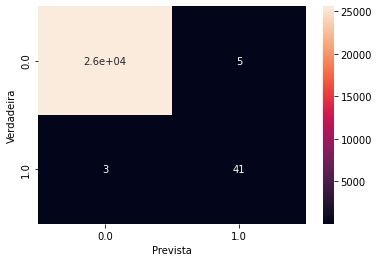

In [10]:
transformed_y_val = y_val.to_numpy().reshape(1, len(y_val))
confusion_matrix = pd.crosstab(transformed_y_val, pred, rownames=['Verdadeira'], colnames=['Prevista']);
sn.heatmap(confusion_matrix, annot=True);

In [18]:
tamanho_eixoX = 20
tamanho_eixoY = 10

#X_tr = X_tr.to_numpy()
#y_tr = y_tr.to_numpy()

X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

### Treino: Acerto e Erro

Taxa de acerto: 1.0


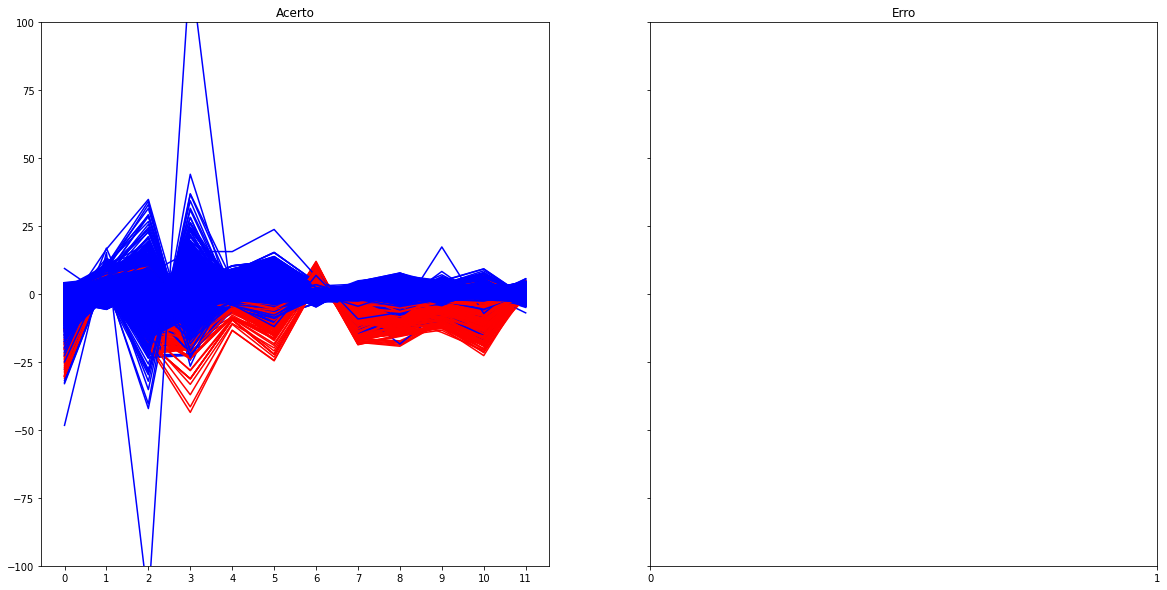

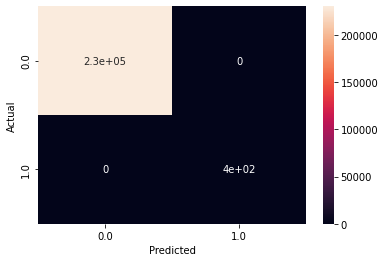

In [15]:
fig, (acerto, erro) = plt.subplots(1, 2, sharey=True, figsize=(tamanho_eixoX, tamanho_eixoY))

acerto.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))
erro.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))

acerto.set_title("Acerto")
erro.set_title("Erro")

contador_acertos = 0
predicao = modelo_predict(modelo, X_tr)
i = 0
for pred in predicao:
  if pred == y_tr[i]:
    contador_acertos += 1
    if y_tr[i] == 0:
      acerto.plot(X_tr[i,:-1], '-b')
    else:
      acerto.plot(X_tr[i,:-1], '-r')
  else:
    if y_tr[i] == 0:
      erro.plot(X_tr[i,:-1], '-b')
    else:
      erro.plot(X_tr[i,:-1], '-r')
  i += 1
      
print(f"Taxa de acerto: {contador_acertos/len(X_tr)}")
plt.ylim([-100,100])
plt.show()

confusion_matrix = pd.crosstab(y_tr.reshape(1, len(y_tr)), predicao, rownames=['Actual'], colnames=['Predicted']);
sn.heatmap(confusion_matrix, annot=True);

### Validacao: Acerto e Erro

KeyError: (slice(None, None, None), slice(None, -1, None))

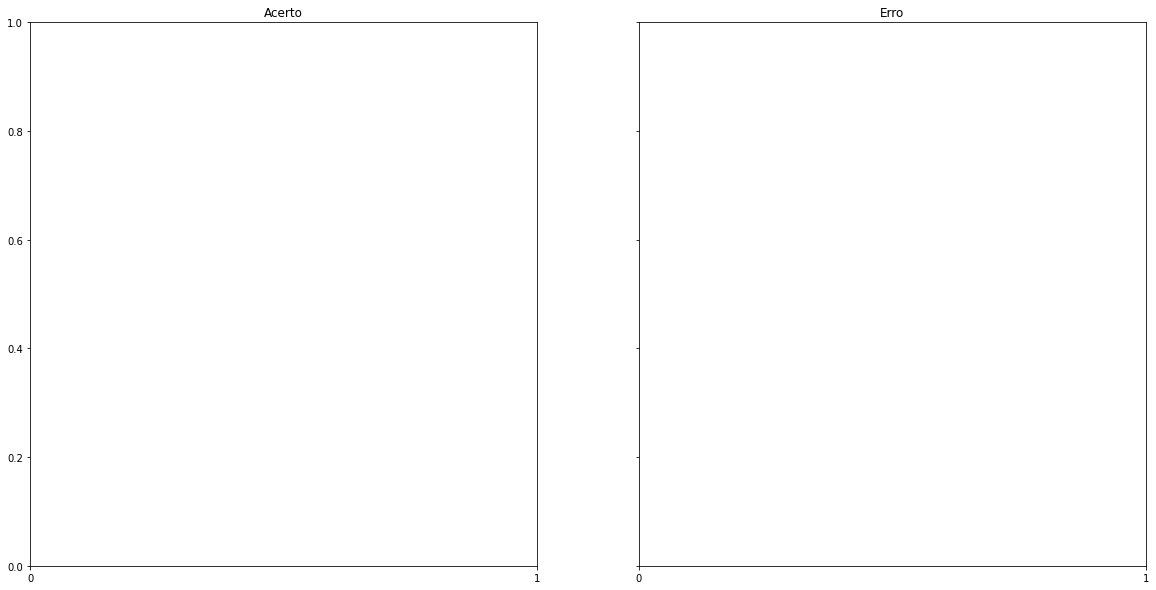

In [16]:
fig, (acerto, erro) = plt.subplots(1, 2, sharey=True, figsize=(tamanho_eixoX, tamanho_eixoY))

acerto.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))
erro.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))

acerto.set_title("Acerto")
erro.set_title("Erro")

contador_acertos = 0

predicao = modelo_predict(modelo, X_val)
i = 0

colunas_dataframe = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19']
dt_v = pd.DataFrame(X_val[:, :-1], columns=colunas_dataframe)

for pred in predicao:
  if pred == y_val[i]:
    contador_acertos += 1
    if y_val[i] == 0:
      acerto.plot(X_val[i,:-1], '-b')
    else:
      acerto.plot(X_val[i,:-1], '-r')
  else:
    if y_val[i] == 0:
      erro.plot(X_val[i,:-1], '-b')
    else:
      erro.plot(X_val[i,:-1], '-r')

  i += 1

print(f"Taxa de acerto: {contador_acertos/len(X_val)}")
plt.ylim([-100,100])
plt.show()

confusion_matrix = pd.crosstab(y_val.reshape(1, len(y_val)), predicao, rownames=['Actual'], colnames=['Predicted']);
sn.heatmap(confusion_matrix, annot=True);

### Teste: Acerto e Erro

Taxa de acerto: 0.9991924440855307


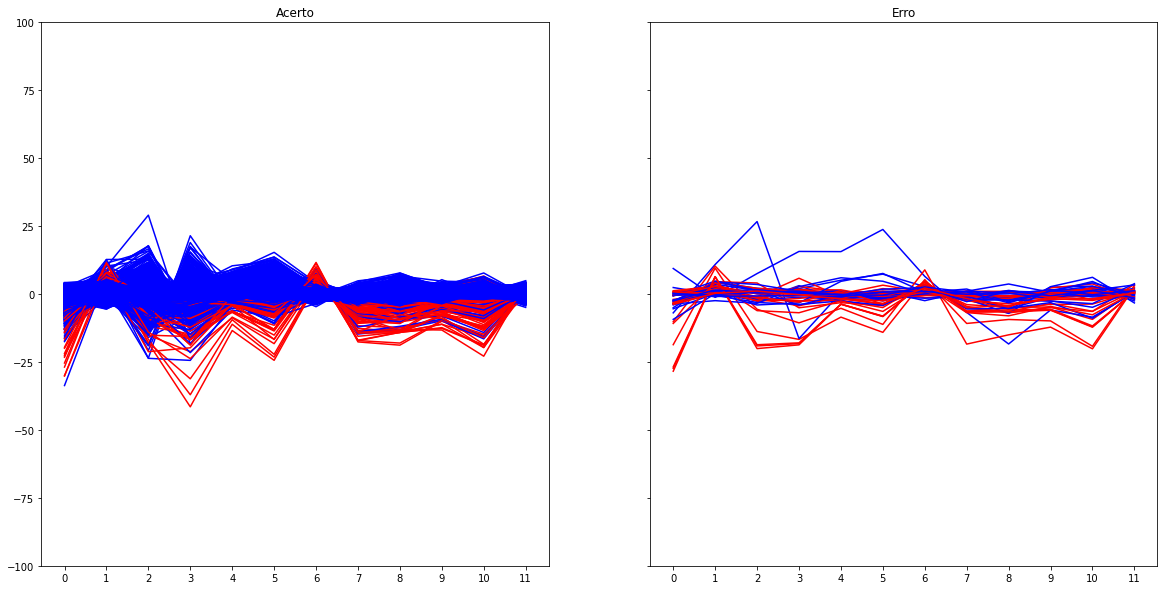

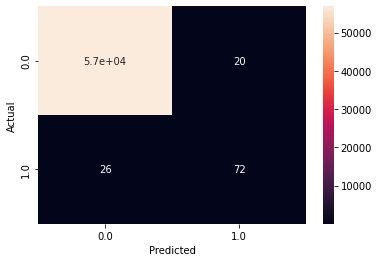

In [20]:
fig, (acerto, erro) = plt.subplots(1, 2, sharey=True, figsize=(tamanho_eixoX, tamanho_eixoY))

acerto.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))
erro.xaxis.set_major_locator(eval("plt.MultipleLocator(1.0)"))

acerto.set_title("Acerto")
erro.set_title("Erro")

X_testing = X_test
y_testing = y_test

contador_acertos = 0
predicao = modelo_predict(modelo, X_testing)
i = 0
for pred in predicao:
  if pred == y_testing[i]:
    contador_acertos += 1
    if y_testing[i] == 0:
      acerto.plot(X_testing[i,:-1], '-b')
    else:
      acerto.plot(X_testing[i,:-1], '-r')
  else:
    if y_testing[i] == 0:
      erro.plot(X_testing[i,:-1], '-b')
    else:
      erro.plot(X_testing[i,:-1], '-r')
  i += 1
      
print(f"Taxa de acerto: {contador_acertos/len(X_testing)}")
plt.ylim([-100,100])
plt.show()

confusion_matrix = pd.crosstab(y_testing.reshape(1, len(y_testing)), predicao, rownames=['Actual'], colnames=['Predicted']);
sn.heatmap(confusion_matrix, annot=True);

# Salvamento manual

In [9]:
break
colunas_dataframe = ['V3', 'V4', 'V5', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V19', 'Amount']

df_train = pd.DataFrame(X_tr, columns=colunas_dataframe)
df_train['Classe'] = y_train
# df_train.to_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/treino.csv')
df_train.to_csv('./treino.csv')

df_val = pd.DataFrame(X_val, columns=colunas_dataframe)
df_val['Classe'] = y_val
# df_train.to_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/validacao.csv')
df_val.to_csv('./validacao.csv')

df_test = pd.DataFrame(X_test, columns=colunas_dataframe)
df_test['Classe'] = y_test
# df_train.to_csv('/content/drive/MyDrive/PD_Onca_Pintada/Projeto/Data/teste.csv')
df_test.to_csv('./teste.csv')